# 1. Importing library and setting device

In [1]:
import torch  # Pytorch
import torch.nn as nn  # Neural network module
import torch.nn.functional as fn  # Function module
from torchvision import datasets  # Datasets from torchvision
from torchvision import transforms  # Transforms from torchvision
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

import matplotlib.pyplot as plt  # Plotting using matplotlib
import numpy as np  # Numpy


if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print("Running on " + device)

Running on cuda


# 2. Preparing dataset

In [2]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

from torchvision.datasets import MNIST

transform = transforms.ToTensor()

train_data = MNIST("./", download=True, train=True, transform=transform)
test_data = MNIST("./", download=True, train=False, transform=transform)

X_train, X_test = train_test_split(train_data, test_size=0.05, random_state=42)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# 3. Autoencoder architecture

In [3]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(True),
            nn.Linear(512, 128),
            nn.ReLU(True), 
            nn.Linear(128, 64), 
            nn.ReLU(True), 
            nn.Linear(64, 9),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(9, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 512),
            nn.ReLU(True), 
            nn.Linear(512, 28 * 28),
            nn.Sigmoid())

    def forward(self, x):
        x = torch.flatten(x, start_dim = 1)
        x = self.encoder(x)
        x = self.decoder(x)
        x.reshape((-1,1,28,28))
        return x

autoencoder = autoencoder().to(device)

# 4. Loss function

In [4]:
def get_loss(pred, original):
    # penalty function
    # 0 at window[391] and 1 elsewhere
    window = torch.ones(784)
    window[391] = 0
    window = window.to(device)

    lw = 784

    # Creating toeplitz matrix A
    x = torch.flatten(original, start_dim=1).squeeze().to(device)
    # x = original.view(784).to(device)
    z = torch.zeros(lw-1).to(device)
    x = torch.cat([x, z], dim = 0)
    A_T = torch.zeros((lw, len(x))).to(device)
    for j in range(lw):
        A_T[j] = torch.roll(x, j)
    A = torch.transpose(A_T, 0, 1)
    # Creating padded vector b
    b = torch.flatten(pred, start_dim=1).squeeze().to(device)
    # b = pred.view(784).to(device)
    n = 2*lw-1-28*28
    l = np.floor(n/2)
    r = n-l
    bz0 = torch.zeros(int(l)).to(device)
    bz1 = torch.zeros(int(r)).to(device)
    b = torch.cat([bz0, b, bz1], dim = 0).to(device)
    # Calculating filter w with length of lw
    inv = torch.inverse(A_T @ A)
    # inv = inv.to(device)
    w = inv @ A_T @ b

    # w2 = w.cpu().detach().numpy()
    # plt.plot(w2)
    # plt.show()

    # Calculating loss for pred[k]
    loss = 0.5 * torch.sum((window * w)**2) 
    
    return loss.to(device)


# 5. Training function

Epoch: 1 	Training Loss: 0.181051
Epoch: 2 	Training Loss: 0.177040
Epoch: 3 	Training Loss: 0.173420
Epoch: 4 	Training Loss: 0.170153
Epoch: 5 	Training Loss: 0.167182
Epoch: 6 	Training Loss: 0.164458
Epoch: 7 	Training Loss: 0.161936
Epoch: 8 	Training Loss: 0.159587
Epoch: 9 	Training Loss: 0.157366
Epoch: 10 	Training Loss: 0.155251
Epoch: 11 	Training Loss: 0.153221
Epoch: 12 	Training Loss: 0.151261
Epoch: 13 	Training Loss: 0.149360
Epoch: 14 	Training Loss: 0.147506
Epoch: 15 	Training Loss: 0.145694
Epoch: 16 	Training Loss: 0.143917
Epoch: 17 	Training Loss: 0.142171
Epoch: 18 	Training Loss: 0.140454
Epoch: 19 	Training Loss: 0.138762
Epoch: 20 	Training Loss: 0.137089
Epoch: 21 	Training Loss: 0.135430
Epoch: 22 	Training Loss: 0.133780
Epoch: 23 	Training Loss: 0.132135
Epoch: 24 	Training Loss: 0.130493
Epoch: 25 	Training Loss: 0.128852
Epoch: 26 	Training Loss: 0.127209
Epoch: 27 	Training Loss: 0.125563
Epoch: 28 	Training Loss: 0.123911
Epoch: 29 	Training Loss: 0.1

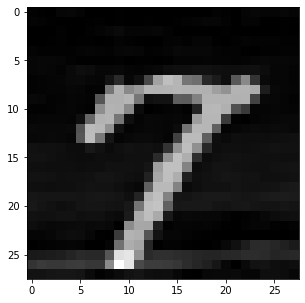

In [5]:
def train(autoencoder, train_image, kl_div_on=True, n_epochs=100):
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0001)
    for epoch in range(1, n_epochs+1):
        # monitor training loss
        train_loss = 0.0
      
        ###################
        # train the model #
        ###################
        
        # model.train()
        # _ stands in for labels, here
        # no need to flatten images
        image, y = train_image
        image = image.view((1, 1, 28, 28))
        image = image.to(device)
        #images = images.to(device)
        optimizer.zero_grad()
        pred = autoencoder(image)
        pred = pred.view((1, 1, 28, 28))

        loss = get_loss(pred, image)

        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()
                
        # print avg training statistics 
        train_loss = train_loss
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, 
            train_loss
            ))
    return autoencoder

# one image for training
tao_train = X_train[0]
autoencoder = train(autoencoder, tao_train, n_epochs = 1000)


import matplotlib.pyplot as plt
%matplotlib inline


a, b = tao_train
a = a.view((1, 1, 28, 28)).to(device)
p = autoencoder(a)
p = p.view((1, 1, 28, 28))
print(p.size())
image = p.cpu().detach().numpy()


img = np.squeeze(image)

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

# 6. The original image

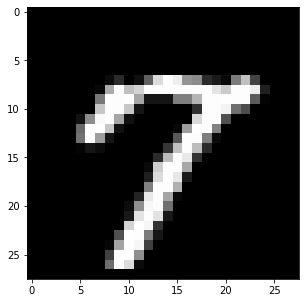

In [6]:
# Original image
tao_train = X_train[0]
a, b = tao_train
a = a.view((1, 1, 28, 28))
image = a.cpu().detach().numpy()


img = np.squeeze(a)

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')